# The Weather Down Under
---
I did you 06-Python-APIs Homework again with the intention of demonstrating how to take the skills you've learned (up until 06-Python-Apis Homework) and tell a better story.  We focus heavily on teaching you the skills you'll need to tell that story but rarely do we actually ask you to tell it.

<br>

I noticed that most of you provided analysis as an afterthought to completing the assignment and that's just plain backwards. 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import datetime as dt
import gmaps.geojson_geometries as gdata
import palettable as pt

# Import API key
from supersecret import owm_key,gmaps_key
gmaps.configure(api_key= gmaps_key)
owm_url = 'http://api.openweathermap.org/data/2.5/weather'

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

## Generate Cities List

In [2]:
# Australia BBox
lat = [-43.897892, -10.660608]
lng = [110.917969,156.708984]

'''
Generate cities based on boundary box of Australia and filter on country code to restrict to only Chad
'''
citySet = set()

while len(citySet) < 300:
    cty_lat = round(np.random.uniform(lat[0],lat[1]),3)
    cty_lng = round(np.random.uniform(lng[0],lng[1]),3)
    city = citipy.nearest_city(cty_lat, cty_lng)
    citySet.add((city.city_name.capitalize(),
                 city.country_code.upper(),
                 cty_lat, cty_lng))
    
# Convert list of tuples into a dataframe
cities_df = pd.DataFrame(citySet, columns =['City', 'Country Code', 'Latitude', 'Longitude']).set_index("City")
cities_df["Temperature"] = np.NaN
cities_df["Humidity"] = np.NaN
cities_df["Cloudiness"] = np.NaN
cities_df["Wind Speed"] = np.NaN

## Perform API Calls

In [3]:
# Get weather info for each city
params = {
    "appid": owm_key,
    "units": 'imperial'
}

# read countries in the dataframe and get weather information for each one
print(f"{'-'*35} Start {'-'*35}")
for idx, value in cities_df.iterrows():
    try:
        
        # add the cityname (and country code) to params dict
        params['q'] = f"{idx},{value['Country Code']}"
        # Call de API and jsonify
        we_info_city = requests.get(owm_url, params=params).json()

        # Add the required information to the dataframe
        cities_df.loc[idx, "Temperature"] = we_info_city["main"]["temp"]
        cities_df.loc[idx, "Humidity"] = we_info_city["main"]["humidity"]
        cities_df.loc[idx, "Cloudiness"] = we_info_city["clouds"]["all"]
        cities_df.loc[idx, "Wind Speed"] = we_info_city["wind"]["speed"]
        ctry_id = we_info_city["id"]
        
        # Let user know of progress        
        print(f"Processing {idx}{'.'*25}", end="\r")

    # catch possible errors if the coordinates do NOT exist, or any of the datapoints in NOT available    
    except (KeyError, IndexError):
        print(f"{idx} not found", end='\r')

# Get rid of any lines with NaN values in any column
print(f"{'-'*35} Done {'-'*36}")
cities_df = cities_df.dropna(axis=0, how="any")
              
# Save the dataframe to a file
cities_df.to_csv("output/cities.csv", index=False, header=True)

----------------------------------- Start -----------------------------------
----------------------------------- Done -----------------------------------


In [4]:
# Confirm filter on Country Code
cities_df=cities_df.loc[cities_df['Country Code']=='AU']
cities_df.head()

,Country Code,Latitude,Longitude,Temperature,Humidity,Cloudiness,Wind Speed
City,,,,,,,
Roma,AU,-27.203,144.196,56.50,58.0,18.0,6.33
Katherine,AU,-16.210,133.038,66.20,52.0,6.0,5.82
Mareeba,AU,-13.747,143.658,68.90,73.0,90.0,10.29
Mackay,AU,-20.217,151.203,57.43,100.0,75.0,5.82
Gatton,AU,-27.792,152.482,49.91,66.0,90.0,8.05


## Plot Gen

In [189]:
# Define colormaps
temp = pt.cmocean.sequential.Amp_15
humidity = pt.lightbartlein.sequential.Blues7_7
clouds= pt.cmocean.sequential.Gray_15_r
wind = pt.cmocean.sequential.Dense_15

def plot_gen(c,cmap):
    date = dt.date.today().strftime('%m/%d/%Y')
    plot = cities_df.plot.hexbin(x='Longitude',
                                 y='Latitude',
                                 C=c, 
                                 gridsize = 10,
                                 figsize=(6,4),
                                 title=f"Australia {c} for {date}",
                                 cmap=cmap.mpl_colormap)
    plt.xlabel('Longitude')
    plt.tight_layout()
    # Save the chart
    plt.savefig(f"img/Aus_{c}.png")
    # Now we can show the image, otherwise we get a blank png
    plt.show()   

### Find Australia in geojson_geometries

In [135]:
# Loop through countries to match Australia on ISO_A3 Country Code
aus_feature = gdata.load_geometry('countries')
aus_val = 0
for i in range(0,217):
    if aus_feature['features'][i]['properties']['ISO_A3'] == 'AUS':
        break
        aus_val=i
        # Isolate geometry for australia
        aus_geojson={
            "type":"FeatureCollection",
            "features": [aus_feature['features'][aus_val]]
        }
        
# Confirm Accuracy
print(aus_geojson['features'][0]['properties']['name'])

Australia


### Map Gen function

In [192]:
# Set Map Gradient options and convert list of lists to list of tuples
# convert list of lists into list of tuples
def tuplize(cmap):
    colors = [tuple(color) for color in cmap.colors]
    return colors
    
map_temp = tuplize(temp)
map_hum = tuplize(humidity)
map_cloud= tuplize(clouds)
map_wind = tuplize(wind)

def map_gen(column,max_intensity=90, point_radius=20,gradient=map_temp,size=500):
    # Set locations
    locations = cities_df.reset_index()[['Latitude','Longitude']]
    # Weights are equal to column input. i.e. 'Temperature'
    weights = cities_df[[column]].reset_index()[column]
    #Layout
    figure_layout = {
        'width':f'{size}px',
        'margin': '0 auto 0 auto'
    }
    fig = gmaps.figure(center=(-25.522615,135.483398),
                       zoom_level=3.75,
                       map_type='HYBRID',
                       layout=figure_layout)
    # Set heatmap_layer values to function parameters and default values
    heatmap_layer = gmaps.heatmap_layer(locations,
                                        weights = weights,
                                        point_radius = point_radius,
                                        max_intensity = max_intensity,
                                        gradient=gradient,
                                        opacity=0.7)
    # Chad geojson geometries
    aus_layer = gmaps.geojson_layer(aus_geojson,fill_color=(0,0,0,0.9))
    fig.add_layer(aus_layer)
    fig.add_layer(heatmap_layer)

    return fig

## Latitude vs. Temperature

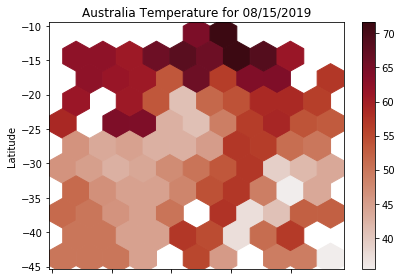

In [193]:
plot_gen('Temperature',temp)

In [201]:
map_gen('Temperature',max_intensity=400,point_radius=60)

Figure(layout=FigureLayout(height='420px', margin='0 auto 0 auto', width='500px'))

## Latitude vs. Humidity Plot

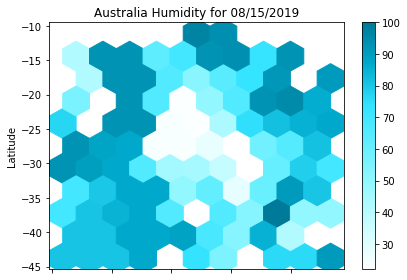

<Figure size 432x288 with 0 Axes>

In [152]:
plot_gen('Humidity', humidity)

In [155]:
map_gen('Humidity',max_intensity=450,point_radius=30,gradient=map_hum)

Figure(layout=FigureLayout(height='420px', margin='0 auto 0 auto', width='500px'))

## Latitude vs. Cloudiness Plot

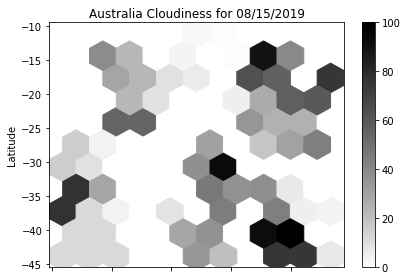

<Figure size 432x288 with 0 Axes>

In [156]:
plot_gen('Cloudiness',clouds)

In [159]:
map_gen("Cloudiness",max_intensity=300,point_radius=40,gradient=map_cloud)

Figure(layout=FigureLayout(height='420px', margin='0 auto 0 auto', width='500px'))

## Latitude vs. Wind Speed Plot

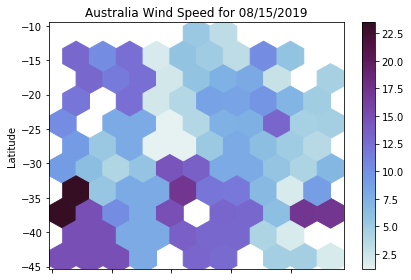

<Figure size 432x288 with 0 Axes>

In [161]:
plot_gen('Wind Speed',wind)

In [191]:
map_gen('Wind Speed',max_intensity=200,point_radius=45,gradient=map_wind)

Figure(layout=FigureLayout(height='420px', margin='0 auto 0 auto', width='500px'))